In [1]:
from tensorflow.python.client import device_lib 
import tensorflow as tf
print(device_lib.list_local_devices())
tf.config.experimental.list_physical_devices('GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6292603544076367484
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4268752896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 760055219429945090
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import h5py
h5py.run_tests()

Tests require pytest, pytest not installed


1

In [3]:
# Lyes @2022
# The data could be found in http://keddiyan.com/files/PowerForecast.html
# and T.-Y. Kim and S.-B. Cho, ‘‘Predicting residential energy consumption using CNN–LSTM neural networks,’’ Energy, vol. 182, pp. 72–81, Sep. 2019.
# https://towardsdatascience.com/the-time-series-transformer-2a521a0efad3

#https://github.com/LyesSaadSaoud/House_transformer/blob/main/Transformers_Houses1to5_5min.py
import sys
sys.path.append("mypath")


import numpy as np
import pandas as pd
import math
import os, datetime
import tensorflow as tf
# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
import time
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pywt

from numpy.random import seed
# plt.style.use('seaborn')
plt.style.use('seaborn-v0_8')

from tqdm.auto import tqdm

In [4]:
dtype = {
    'Year': 'Int64',
    'Month': 'Int64',
    'Day': 'Int64',
    'Hour': 'Int64',
    'Minute': 'Int64',
    'Global_active_power':'float32',
    'Global_reactive_power':'float32',
    'Voltage;Global_intensity':'float32',
    'Sub_metering_1':'float32',
    'Sub_metering_2':'float32',
    'Sub_metering_3':'float32'
}

def save_result(y_test,predicted_values):
    np.savetxt('./T_SWT_house4_min5_test.csv',y_test) # save path
    np.savetxt('./T_SWT_house4_min5_predicted.csv',predicted_values) # save path

df = pd.read_csv('./data ukdale/house1_5mins.csv', dtype=dtype)  # path to data

def data_preparation(dataset, window, lev):
    da = []
    for i in range(len(dataset)-window):
        coeffs = pywt.swt(dataset[i:window+i], wavelet='db2', level=lev)
        da.append(coeffs);
    return da

def data_reconstruction(dataset,window):
    da = []
    for i in tqdm(range(len(dataset)), total= len(dataset), desc="iswt"):
#         recon = pywt.iswt(dataset[i,:,:,:].tolist(), 'db2')
        recon = pywt.iswt(dataset[i], 'db2')
#         print(np.array(recon).shape)
        da.append(recon[window-1])
#         da.append(recon[0][window-1])
    return da


# Called because iswt cannot accept tolist() dataset
def data_organization(coeffs):
    '''
    Reshape data back to (n,3,2,window_length), where there are 3 tuples of 2 values consisting of 
    coeffs array_like Coefficients list of tuples:
    [(cAn, cDn), ..., (cA2, cD2), (cA1, cD1)]
    '''
    reshape_list = []
    for i in range(len(coeffs)):
        reshape_list.append([])
        for j in range(len(coeffs[0])):
            reshape_list[i].append(tuple(coeffs[i][j]))
            
    return reshape_list

def create_dataset(dataset, look_back):
    dataX,dataY=[],[]

    for i in range(len(dataset)-look_back):
        a=dataset[i:(i+look_back),0:4]
        dataX.append(a)
        dataY.append(dataset[i+look_back,0:4])
    return np.array(dataX),np.array(dataY)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class Time2Vector(Layer):
#     ''' https://arxiv.org/abs/1907.05321'''
#     def __init__(self, seq_len, **kwargs):
#         super(Time2Vector, self).__init__()
#         self.seq_len = seq_len

#     def build(self, input_shape):
#         self.weights_linear = self.add_weight(name='weight_linear',
#                                               shape=(int(self.seq_len),),
#                                               initializer='uniform',
#                                               trainable=True)

#         self.bias_linear = self.add_weight(name='bias_linear',
#                                            shape=(int(self.seq_len),),
#                                            initializer='uniform',
#                                            trainable=True)

#         self.weights_periodic = self.add_weight(name='weight_periodic',
#                                                 shape=(int(self.seq_len),),
#                                                 initializer='uniform',
#                                                 trainable=True)

#         self.bias_periodic = self.add_weight(name='bias_periodic',
#                                              shape=(int(self.seq_len),),
#                                              initializer='uniform',
#                                              trainable=True)

#     def call(self, x):

#         x = tf.math.reduce_mean(x[:, :, :4], axis=-1)
#         time_linear = self.weights_linear * x + self.bias_linear
#         time_linear = tf.expand_dims(time_linear, axis=-1)

#         time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
#         time_periodic = tf.expand_dims(time_periodic, axis=-1)
#         return tf.concat([time_linear, time_periodic], axis=-1)

#     def get_config(self):
#         config = super().get_config().copy()
#         config.update({'seq_len': self.seq_len})
#         return config
    
class Time2Vector(nn.Module):
    def __init__(self, seq_len):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

        self.weights_linear = nn.Parameter(torch.rand(seq_len, requires_grad=True))
        self.bias_linear = nn.Parameter(torch.rand(seq_len), requires_grad=True)
        self.weights_periodic = nn.Parameter(torch.rand(seq_len), requires_grad=True)
        self.bias_periodic = nn.Parameter(torch.rand(seq_len), requires_grad=True)
        
        # Initialize parameters with uniform distribution
        nn.init.uniform_(self.weights_linear, a=0.0, b=1.0)
        nn.init.uniform_(self.bias_linear, a=0.0, b=1.0)
        nn.init.uniform_(self.weights_periodic, a=0.0, b=1.0)
        nn.init.uniform_(self.bias_periodic, a=0.0, b=1.0)

    def forward(self, x):
        x = torch.mean(x[:, :, :], dim=-1)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = time_linear.unsqueeze(-1)

        time_periodic = torch.sin(x * self.weights_periodic + self.bias_periodic)
        time_periodic = time_periodic.unsqueeze(-1)

        return torch.cat([time_linear, time_periodic], dim=-1)

    def extra_repr(self):
        return f'seq_len={self.seq_len}'

In [6]:
# class SingleAttention(Layer):
#     def __init__(self, d_k, d_v):
#         super(SingleAttention, self).__init__()
#         self.d_k = d_k
#         self.d_v = d_v

#     def build(self, input_shape):
#         self.query = Dense(self.d_k,
#                            input_shape=input_shape,
#                            kernel_initializer='glorot_uniform',
#                            bias_initializer='glorot_uniform')

#         self.key = Dense(self.d_k,
#                          input_shape=input_shape,
#                          kernel_initializer='glorot_uniform',
#                          bias_initializer='glorot_uniform')

#         self.value = Dense(self.d_v,
#                            input_shape=input_shape,
#                            kernel_initializer='glorot_uniform',
#                            bias_initializer='glorot_uniform')

#     def call(self, inputs):
#         q = self.query(inputs[0])
#         k = self.key(inputs[1])

#         attn_weights = tf.matmul(q, k, transpose_b=True)
#         attn_weights = tf.map_fn(lambda x: x / np.sqrt(self.d_k), attn_weights)
#         attn_weights = tf.nn.softmax(attn_weights, axis=-1)

#         v = self.value(inputs[2])
#         attn_out = tf.matmul(attn_weights, v)
#         return attn_out

class SingleAttention(nn.Module):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

        self.query = nn.Linear(in_features=8, out_features=d_k)
        nn.init.xavier_uniform_(self.query.weight)
        nn.init.zeros_(self.query.bias)

        self.key = nn.Linear(in_features=8, out_features=d_k)
        nn.init.xavier_uniform_(self.key.weight)
        nn.init.zeros_(self.key.bias)

        self.value = nn.Linear(in_features=8, out_features=d_v)
        nn.init.xavier_uniform_(self.value.weight)
        nn.init.zeros_(self.value.bias)

    def forward(self, inputs):

        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = torch.matmul(q, k.transpose(-2, -1))
        attn_weights = attn_weights / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        attn_weights = F.softmax(attn_weights, dim=-1)

        v = self.value(inputs[2])
        attn_out = torch.matmul(attn_weights, v)
        return attn_out

In [7]:
# class MultiAttention(Layer):
#     def __init__(self, d_k, d_v, n_heads):
#         super(MultiAttention, self).__init__()
#         self.d_k = d_k
#         self.d_v = d_v
#         self.n_heads = n_heads
#         self.attn_heads = list()

#     def build(self, input_shape):
#         for n in range(self.n_heads):
#             self.attn_heads.append(SingleAttention(self.d_k, self.d_v))
#         self.linear = Dense(input_shape[0][-1],
#                             input_shape=input_shape,
#                             kernel_initializer='glorot_uniform',
#                             bias_initializer='glorot_uniform')

#     def call(self, inputs):
#         attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
#         concat_attn = tf.concat(attn, axis=-1)
#         multi_linear = self.linear(concat_attn)
#         return multi_linear
    
class MultiAttention(nn.Module):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        
        self.attn_heads = nn.ModuleList([SingleAttention(d_k, d_v) for _ in range(n_heads)])
        
        self.linear = nn.Linear(d_k * n_heads, 8)
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = torch.cat(attn, dim=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear

In [8]:
# class TransformerEncoder(Layer):
#     def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
#         super(TransformerEncoder, self).__init__()
#         self.d_k = d_k
#         self.d_v = d_v
#         self.n_heads = n_heads
#         self.ff_dim = ff_dim
#         self.attn_heads = list()
#         self.dropout_rate = dropout

#     def build(self, input_shape):
#         self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
#         self.attn_dropout = Dropout(self.dropout_rate)
#         self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

#         self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
#         self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
#         self.ff_dropout = Dropout(self.dropout_rate)
#         self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

#     def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
#         attn_layer = self.attn_multi(inputs)
#         attn_layer = self.attn_dropout(attn_layer)
#         attn_layer = self.attn_normalize(inputs[0] + attn_layer)

#         ff_layer = self.ff_conv1D_1(attn_layer)
#         ff_layer = self.ff_conv1D_2(ff_layer)
#         ff_layer = self.ff_dropout(ff_layer)
#         ff_layer = self.ff_normalize(inputs[0] + ff_layer)
#         return ff_layer

#     def get_config(self):
#         config = super().get_config().copy()
#         config.update({'d_k': self.d_k,
#                        'd_v': self.d_v,
#                        'n_heads': self.n_heads,
#                        'ff_dim': self.ff_dim,
#                        'attn_heads': self.attn_heads,
#                        'dropout_rate': self.dropout_rate})
#         return config

    
class TransformerEncoder(nn.Module):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout

        self.attn_multi = MultiAttention(d_k, d_v, n_heads)
        self.attn_dropout = nn.Dropout(dropout)
        self.attn_normalize = nn.LayerNorm(normalized_shape=8, eps=1e-6)

#         self.ff_conv1D_1 = nn.Conv1d(in_channels=8, out_channels=self.ff_dim, kernel_size=1)
        self.ff_conv1D_1 = nn.Conv1d(in_channels=1, out_channels=self.ff_dim, kernel_size=1)
#         self.ff_conv1D_2 = nn.Conv1d(in_channels=self.ff_dim, out_channels=8, kernel_size=1)
        self.ff_conv1D_2 = nn.Conv1d(in_channels=self.ff_dim, out_channels=1, kernel_size=1)
        self.ff_dropout = nn.Dropout(dropout)
        self.ff_normalize = nn.LayerNorm(normalized_shape=8, eps=1e-6)

    def forward(self, inputs):
#         print(len(inputs))
#         print(inputs[0].shape)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        # Correction for transpose
#         ff_layer = self.ff_conv1D_1(attn_layer.transpose(1, 2))
        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = F.relu(ff_layer)
#         ff_layer = self.ff_conv1D_2(ff_layer).transpose(1, 2)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer

In [9]:
# class TransformerDecoder(Layer):
#     def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
#         super(TransformerDecoder, self).__init__()
#         self.d_k = d_k
#         self.d_v = d_v
#         self.n_heads = n_heads
#         self.ff_dim = ff_dim
#         self.attn_heads = list()
#         self.dropout_rate = dropout

#     def build(self, input_shape):
#         self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
#         self.attn_dropout = Dropout(self.dropout_rate)
#         self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

#         self.ff_conv1D_1 = Conv1D(filters=input_shape[0][-1], kernel_size=1, activation='relu')
#         self.ff_dropout = Dropout(self.dropout_rate)
#         self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

#     def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
#         attn_layer = self.attn_multi(inputs)
#         attn_layer = self.attn_dropout(attn_layer)
#         attn_layer = self.attn_normalize(inputs[0] + attn_layer)

#         ff_layer = self.ff_conv1D_1(attn_layer)
#         ff_layer = self.ff_dropout(ff_layer)
#         ff_layer = self.ff_normalize(inputs[0] + ff_layer)
#         return ff_layer

#     def get_config(self):  # Needed for saving and loading model with custom layer
#         config = super().get_config().copy()
#         config.update({'d_k': self.d_k,
#                        'd_v': self.d_v,
#                        'n_heads': self.n_heads,
#                        'ff_dim': self.ff_dim,
#                        'attn_heads': self.attn_heads,
#                        'dropout_rate': self.dropout_rate})
#         return config

class TransformerDecoder(nn.Module):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout

        self.attn_multi = MultiAttention(d_k, d_v, n_heads)
        self.attn_dropout = nn.Dropout(dropout)
        self.attn_normalize = nn.LayerNorm(normalized_shape=8, eps=1e-6)

#         self.ff_conv1D_1 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=1)
        self.ff_conv1D_1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=1)
        self.ff_dropout = nn.Dropout(dropout)
        self.ff_normalize = nn.LayerNorm(normalized_shape=8, eps=1e-6)

    def forward(self, inputs):
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)
        
        # Transpose for pytorch implementation
#         ff_layer = self.ff_conv1D_1(attn_layer.transpose(1, 2)).transpose(1, 2)
        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = F.relu(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer

In [10]:
# def create_model():
#   time_embedding = Time2Vector(seq_len)
#   layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#   layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#   layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#   layer4 = TransformerDecoder(d_k, d_v, n_heads, ff_dim)
#   layer5 = TransformerDecoder(d_k, d_v, n_heads, ff_dim)
#   in_seq = Input(shape=(seq_len, inp_len))

#   x = time_embedding(in_seq)
#   x = Concatenate(axis=-1)([in_seq, x])
#   x = layer1((x, x, x))
#   x = layer2((x, x, x))
#   x = layer3((x, x, x))
#   x = layer4((x, x, x))
#   x = layer5((x, x, x))
#   x = GlobalAveragePooling1D(data_format='channels_first')(x)
#   x = Dropout(0.1)(x)
#   x = Dense(128, activation='relu')(x)
#   x = Dropout(0.1)(x)
#   out = Dense(out_len, activation='linear')(x)

#   model = Model(inputs=in_seq, outputs=out)
#   model.compile(loss='mse', optimizer='RMSProp', metrics=['mae', 'mape'])
#   return model

# Put inside nn.module for model.parameters
# def create_model(seq_len, inp_len, out_len, d_k, d_v, n_heads, ff_dim):
#     time_embedding = Time2Vector(seq_len)
#     layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#     layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#     layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
#     layer4 = TransformerDecoder(d_k, d_v, n_heads, ff_dim)
#     layer5 = TransformerDecoder(d_k, d_v, n_heads, ff_dim)

#     # Create required shape tensor for time embedding
#     in_seq = torch.rand(1,seq_len, inp_len)
# #     print(in_seq.shape)

#     x = time_embedding(in_seq)
# #     print(x.shape)
#     x = torch.cat([in_seq, x], dim=-1)
# #     print(x.shape)
    
#     x = layer1((x, x, x))
#     x = layer2((x, x, x))
#     x = layer3((x, x, x))
#     x = layer4((x, x, x))
#     x = layer5((x, x, x))

#     # Global Average Pooling along the sequence dimension
#     x = F.adaptive_avg_pool1d(x, 1).squeeze(2)
    
#     x = F.dropout(x, p=0.1)
#     x = F.relu(nn.Linear(x.size(1), 128)(x))
#     x = F.dropout(x, p=0.1)
#     out = nn.Linear(128, out_len)(x)

#     return out

class SWT_Transformer(nn.Module):
    def __init__(self, seq_len, inp_len, out_len, d_k, d_v, n_heads, ff_dim):
        super(SWT_Transformer, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.time_embedding = Time2Vector(seq_len)
        
        self.layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
        self.layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
        self.layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
        self.layer4 = TransformerDecoder(d_k, d_v, n_heads, ff_dim)
        self.layer5 = TransformerDecoder(d_k, d_v, n_heads, ff_dim)

        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(seq_len, 128)
        self.fc2 = nn.Linear(128, out_len)

    def forward(self, x):
        in_seq = x
        
        time_embedding = self.time_embedding(in_seq)
        x = torch.cat([in_seq, time_embedding], dim=-1)
        
        x = self.layer1((x, x, x))
        x = self.layer2((x, x, x))
        x = self.layer3((x, x, x))
        x = self.layer4((x, x, x))
        x = self.layer5((x, x, x))

        x = self.pooling(x).squeeze(2)
        x = F.dropout(x, p=0.1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.1)
        out = self.fc2(x)

        return out

In [11]:
batch_size = 32
seq_len = 1
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
lev=3
inp_len=2*lev
out_len=2*lev
window = 200
look_back = 12

In [12]:
# print(df.head())
# print(df.dtypes)
dataset = df['Volt-Ampere'].values
dataset=dataset.astype('float32')

# print("Dataset Shape:", dataset.shape)
# print("Dataset Length:", len(dataset))

s = dataset[:12000*3]
# s = np.squeeze(dataset[:12000*3], axis=1)  #

# Get the maximum decomposition level
max_level = pywt.swt_max_level(len(s))
print("Maximum decomposition level:", max_level)

print(s.shape)

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
print(type(s))
da=data_preparation(s, window, lev)
# print(da[0][0])

Vv = np.array(da)
print(Vv.shape)
# print(Vv[0][0])

vv = Vv.reshape(Vv.shape[0],2*lev*Vv.shape[3])
print(vv.shape)


dataset = scaler.fit_transform(vv)
print(dataset.shape)

dat = dataset.reshape(Vv.shape[0],2*lev,Vv.shape[3])
print(dat.shape)

Maximum decomposition level: 5
(36000,)
<class 'numpy.ndarray'>
(35800, 3, 2, 200)
(35800, 1200)
(35800, 1200)
(35800, 6, 200)


In [13]:
print(dat.shape)
alpha=0.6667

# alpha = 0.6
# beta = 0.8

trainX,trainY=dat[:int(dat.shape[0]*alpha),:,window-seq_len-1:window-1],dat[:int(dat.shape[0]*alpha),:,window-1]
testX,testY=dat[int(dat.shape[0]*alpha):,:,window-seq_len-1:window-1],dat[int(dat.shape[0]*alpha):,:,window-1]
testX_a, testY_a = dat[:,:,window-seq_len-1:window-1],dat[:,:,window-1]

print(trainX.shape)
print(testX.shape)
print(testX_a.shape)
print(trainY.shape)

testX_a=np.transpose(testX_a, (0, 2, 1))
trainX=np.transpose(trainX, (0, 2, 1))
testX =np.transpose(testX, (0, 2, 1))

print(testX_a.shape)
print(trainX.shape)
print(testX.shape)



(35800, 6, 200)
(23867, 6, 1)
(11933, 6, 1)
(35800, 6, 1)
(23867, 6)
(35800, 1, 6)
(23867, 1, 6)
(11933, 1, 6)


In [14]:
# model = create_model()
# model.summary()

# # Training data
# X_train, y_train = trainX,trainY
# ###############################################################################
# # Validation data
# X_val, y_val = testX,testY
# ###############################################################################
# # Test data
# X_test, y_test = testX_a,testY_a
# callback = tf.keras.callbacks.ModelCheckpoint('Transformer_5min.hdf5',
#                                                       monitor='val_loss',
#                                                       save_best_only=True,
#                                                       verbose=1)
# with tf.device("/gpu:0"):
#     history = model.fit(X_train, y_train,
#                             batch_size=batch_size,
# #                             epochs=50,
#                             epochs=1,
#                             validation_data=(X_val, y_val),
#                             callbacks=[callback])

# model = tf.keras.models.load_model('Transformer_5min.hdf5',
#                                            custom_objects={'Time2Vector': Time2Vector,
#                                                            'SingleAttention': SingleAttention,
#                                                            'MultiAttention': MultiAttention,
#                                                            'TransformerEncoder': TransformerEncoder,
#                                                            'TransformerDecoder': TransformerDecoder}
#                                            )

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

torch.manual_seed(42)

# Create PyTorch model
model = SWT_Transformer(seq_len, inp_len, out_len, d_k, d_v, n_heads, ff_dim)

# Print model summary
# print(model)
def num_parameters(m):
  return sum([p.numel() for p in m.parameters()])

parameters = num_parameters(model)

# print(f"Expected number of parameters: {m * dk * dk + m * 1 * 1 * n}")
print(f"Actual number of model parameters: {parameters}")

trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
print(f"Trainable model parameters: {trainable_params}" )

# total_params = 0
# for name, parameter in model.named_parameters():
#     if not parameter.requires_grad:
#         continue
#     params = parameter.numel()
#     print(f"{name}, {params}")
#     total_params+=params
# print(f"Total Trainable Params: {total_params}")
    

# Convert data to PyTorch tensors
X_train, y_train = torch.tensor(trainX), torch.tensor(trainY)
X_val, y_val = torch.tensor(testX), torch.tensor(testY)
X_test, y_test = torch.tensor(testX_a), torch.tensor(testY_a)

# Create DataLoader for training and validation data
train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Optimizer and loss function
optimizer = optim.RMSprop(model.parameters(), lr=0.001, eps=1e-07)
# optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()

Grad_scaler = torch.cuda.amp.GradScaler()

# Training loop
num_epochs = 5  # Replace with your desired number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm(range(num_epochs), total= num_epochs, desc="epochs", position=0, leave=True):
    model.train()
    train_loss = 0.0
    for inputs, targets in tqdm(train_loader, total=len(train_loader), desc="train batches", position=1, leave=True):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        
#         with torch.cuda.amp.autocast(dtype=torch.float16):
#             outputs = model(inputs)
#     #         print("targets: ", targets.shape)
#     #         print("outputs: ", outputs.shape)
#             loss = criterion(outputs, targets)
        
#         optimizer.zero_grad()
#         Grad_scaler.scale(loss).backward()
#         Grad_scaler.step(optimizer)
#         Grad_scaler.update()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
#         for p in model.parameters():
#             print(p.grad.norm())
        
        train_loss += loss.item()
        
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, total=len(val_loader), desc="val batches", position=2, leave=True):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    val_loss /= len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}')

# Save the PyTorch model
torch.save(model.state_dict(), 'transformer_5min.pth')


Actual number of model parameters: 541145
Trainable model parameters: 541145


epochs:   0%|          | 0/5 [00:00<?, ?it/s]

train batches:   0%|          | 0/746 [00:00<?, ?it/s]

val batches:   0%|          | 0/373 [00:00<?, ?it/s]

Epoch 1/5, Training Loss: 0.672965, Validation Loss: 0.532806


train batches:   0%|          | 0/746 [00:00<?, ?it/s]

val batches:   0%|          | 0/373 [00:00<?, ?it/s]

Epoch 2/5, Training Loss: 0.561111, Validation Loss: 0.498416


train batches:   0%|          | 0/746 [00:00<?, ?it/s]

val batches:   0%|          | 0/373 [00:00<?, ?it/s]

Epoch 3/5, Training Loss: 0.519867, Validation Loss: 0.420543


train batches:   0%|          | 0/746 [00:00<?, ?it/s]

val batches:   0%|          | 0/373 [00:00<?, ?it/s]

Epoch 4/5, Training Loss: 0.451307, Validation Loss: 0.392757


train batches:   0%|          | 0/746 [00:00<?, ?it/s]

val batches:   0%|          | 0/373 [00:00<?, ?it/s]

Epoch 5/5, Training Loss: 0.422164, Validation Loss: 0.362909


In [15]:
# Load the PyTorch model
loaded_model = SWT_Transformer(seq_len, inp_len, out_len, d_k, d_v, n_heads, ff_dim)
loaded_model.load_state_dict(torch.load('transformer_5min.pth'))
loaded_model.to(device)
loaded_model.eval()

# Use the whole signal (both train and validation data)
# The metrics are computed only using the validation part.
# This is needed for the signal processing
print(testX.shape)

# Testing the model on the test dataset
test_outputs = []
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in tqdm(test_loader, total=len(test_loader), desc="test batch"):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = loaded_model(inputs)
        test_outputs.append(outputs.cpu().numpy())  # Collect the outputs
        test_loss += criterion(outputs, targets).item()

testPredict_a = np.concatenate(test_outputs, axis=0)  # Concatenate outputs into a single numpy array
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

print(testPredict_a.shape)
d=dat
d[:,:,window-1]=testPredict_a
print(d.shape)
D = d.reshape(d.shape[0],d.shape[1]*d.shape[2])
print(D.shape)

R = scaler.inverse_transform(D)
R = R.reshape(d.shape[0],lev,2,d.shape[2])
print(R.shape)

R = data_organization(R)

re=data_reconstruction(R, window)
Re = np.array(re)
print(Re.shape)

tY = s[window:].reshape(s[window:].shape[0],1)
print(tY.shape)
P1 = Re.reshape(Re.shape[0],1)

testYa=tY[int(tY.shape[0]*alpha):,:] # take only the validation part
testPredicta = P1[int(tY.shape[0]*alpha):, :] # take only the validation part

# Calculate validation loss
predicted_values, y_test=testPredicta[1:], testYa[:-1]
test_rmse = math.sqrt( mean_squared_error(y_test, predicted_values))

test_mae=mean_absolute_error(y_test, predicted_values)
mape=100*np.mean(np.divide(abs(y_test- predicted_values),y_test))

(11933, 1, 6)


test batch:   0%|          | 0/1119 [00:00<?, ?it/s]

Test Loss: 0.3851
(35800, 6)
(35800, 6, 200)
(35800, 1200)
(35800, 3, 2, 200)


iswt:   0%|          | 0/35800 [00:00<?, ?it/s]

(35800,)
(35800, 1)


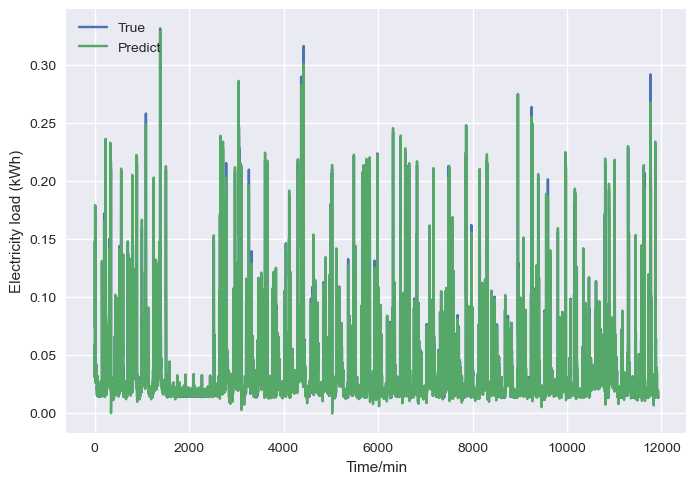

RMSE:  0.0024
MAE:  0.0014
MAPE:  5.7492


In [16]:
fig = plt.figure()
plt.plot(y_test)
plt.plot(predicted_values)
plt.xlabel('Time/min')
plt.ylabel('Electricity load (kWh)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()
print('RMSE:  %.4f' % test_rmse)
print('MAE:  %.4f' % test_mae)
print('MAPE:  %.4f' % mape)

In [17]:
dataset = np.array([i for i in range(1000)])
window = 200
lev = 3

# Get the maximum decomposition level
max_level = pywt.swt_max_level(len(dataset))
print("Maximum decomposition level:", max_level)

coeffs = data_preparation(dataset, window, lev)
# print(np.array(coeffs).shape)
# print(coeffs[0][0])
coeffs = np.array(coeffs)
# print(coeffs.shape)
# print(coeffs[0][0])

coeffs = data_organization(coeffs)

print(np.array(coeffs).shape)
res = data_reconstruction(coeffs,window)
print(res)
np.array(res).shape

Maximum decomposition level: 3
(800, 3, 2, 200)


iswt:   0%|          | 0/800 [00:00<?, ?it/s]

[199.00000000000006, 200.00000000000006, 201.00000000000006, 202.00000000000006, 203.00000000000006, 204.00000000000006, 205.00000000000006, 206.00000000000006, 207.00000000000006, 208.00000000000003, 209.0, 210.00000000000006, 211.00000000000006, 212.0, 213.00000000000006, 214.00000000000003, 215.00000000000006, 216.00000000000006, 217.00000000000006, 218.0, 219.0, 220.00000000000003, 221.00000000000006, 222.00000000000006, 223.0, 224.0, 225.0, 226.0, 227.00000000000006, 228.0, 229.00000000000006, 230.00000000000006, 231.00000000000006, 232.00000000000006, 233.00000000000006, 234.0, 235.00000000000006, 236.00000000000006, 237.00000000000003, 238.00000000000006, 239.00000000000006, 240.00000000000006, 241.00000000000006, 242.00000000000009, 243.00000000000006, 244.00000000000006, 245.00000000000006, 246.00000000000006, 247.00000000000006, 248.0, 249.00000000000006, 250.00000000000003, 251.00000000000006, 252.00000000000006, 253.00000000000006, 254.00000000000006, 255.00000000000003, 25

(800,)

In [18]:
# Saved for full reconstruction
def data_reconstruction(dataset,window):
    da = []
    for i in tqdm(range(len(dataset)), total= len(dataset), desc="iswt"):
#         recon = pywt.iswt(dataset[i,:,:,:].tolist(), 'db2')
        recon = pywt.iswt(dataset[i], 'db2')
#         da.append(recon[window-1])
        da.append(recon)
    return da